In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import time
import json
import joblib

# Your dataset path
# csv_path = "dataset/both_serv.csv"
# csv_path = "dataset/only_int.csv"
csv_path = "dataset/only_ph.csv"

# Load dataset
df = pd.read_csv(csv_path)
num_columns = df.shape[1]
print("Number of columns:", num_columns)
# Extract the base filename without extension
dataset_name = os.path.splitext(os.path.basename(csv_path))[0]

Number of columns: 16


In [26]:
# Separate features (X) and target label (y)
X = df.drop(columns='Churn')
y = df['Churn']

In [27]:
# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [31]:
# Parameter grid for GridSearch
param_grid = {
    "n_estimators": [10, 30, 50, 70, 100, 200, 300, 400, 500, 600, 700, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "base_estimator__max_depth": [1, 2, 3]
}

# Base model for AdaBoost
base_estimator = DecisionTreeClassifier(random_state=42)

# Wrap AdaBoost with the base decision tree
ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Start training
start_time = time.time()
grid_search.fit(X_train, y_train)
train_time = time.time() - start_time

# Best model
best_model = grid_search.best_estimator_

# Print evaluation
print(f"\n✅ GridSearch done in {train_time:.2f} seconds")
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ GridSearch done in 26.19 seconds
Best Parameters: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 10}


C:\Users\Bryon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


ROC AUC Score: 0.7928206715147763

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       281
           1       0.00      0.00      0.00        23

    accuracy                           0.92       304
   macro avg       0.46      0.50      0.48       304
weighted avg       0.85      0.92      0.89       304

Confusion Matrix:


C:\Users\Bryon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bryon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bryon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469

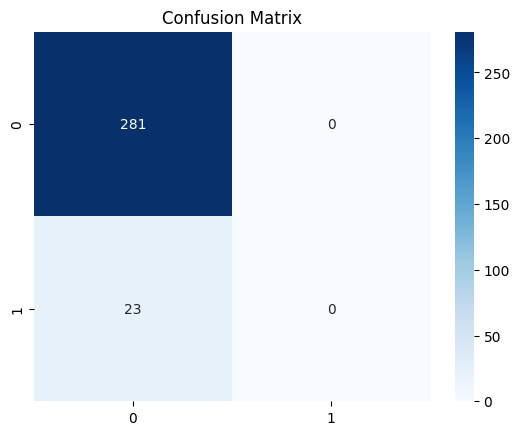

Model saved to: models/adab/20250718_161651_only_ph_adab_model_v1.pkl


C:\Users\Bryon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bryon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bryon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469

In [32]:
# Best model
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Metrics
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Create output dir if missing
os.makedirs("models/adab", exist_ok=True)

# Timestamp for consistency
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')


# Log file name (create one log per run, timestamped)
log_file = f"models/adab/{timestamp}_{dataset_name}_adab_log_v1.txt"

# Safely convert parameters
json_safe_params = {
    k: str(v) if not isinstance(v, (str, int, float, bool, list, dict)) else v
    for k, v in best_model.get_params().items()
}

# Gather key info
log_data = {
    "timestamp": datetime.now().isoformat(),
    "model": "AdaBoost",
    "params": json_safe_params,
    "roc_auc": roc_auc_score(y_test, y_prob),
    "classification_report": classification_report(y_test, y_pred, output_dict=True)
}

# Write to file
with open(log_file, "w") as f:
    f.write(json.dumps(log_data, indent=4))

model_file = f"models/adab/{timestamp}_{dataset_name}_adab_model_v1.pkl"
joblib.dump(best_model, model_file)

print(f"Model saved to: {model_file}")

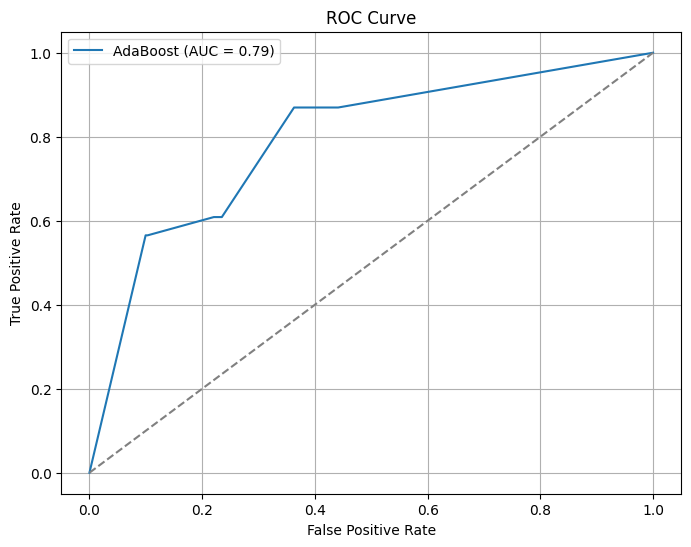

In [30]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AdaBoost (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()